In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium 
import requests
import json
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

hdb_class_data = pd.read_csv("hbd_model_data_classification.csv")

In [4]:
hdb_class_data.head()

,storey_range,floor_area_sqm,no.of bto,resale application,remaining_lease_months,Distance to nearest MRT,Distance to CBD,isMatureEstate,over_under_classification
0,0.0625,0.114583,0.0,0.0,0.229833,0.242702,0.377101,1.0,0
1,0.3750,0.098958,0.0,0.0,0.888889,0.181339,0.376605,1.0,0
2,0.0000,0.114583,0.0,0.0,0.243531,0.153615,0.373691,1.0,0
3,0.0625,0.114583,0.0,0.0,0.223744,0.212727,0.381423,1.0,0
4,0.1250,0.088542,0.0,0.0,0.292237,0.247779,0.408523,1.0,0


### Check distribution of classes

In [5]:
hdb_class_data.groupby("over_under_classification").count()

,storey_range,floor_area_sqm,no.of bto,resale application,remaining_lease_months,Distance to nearest MRT,Distance to CBD,isMatureEstate
over_under_classification,,,,,,,,
0,39783,39783,39783,39783,39783,39783,39783,39783
1,38051,38051,38051,38051,38051,38051,38051,38051


<AxesSubplot:title={'center':'Distribution of Valuation Classifications'}, xlabel='over_under_classification', ylabel='count'>

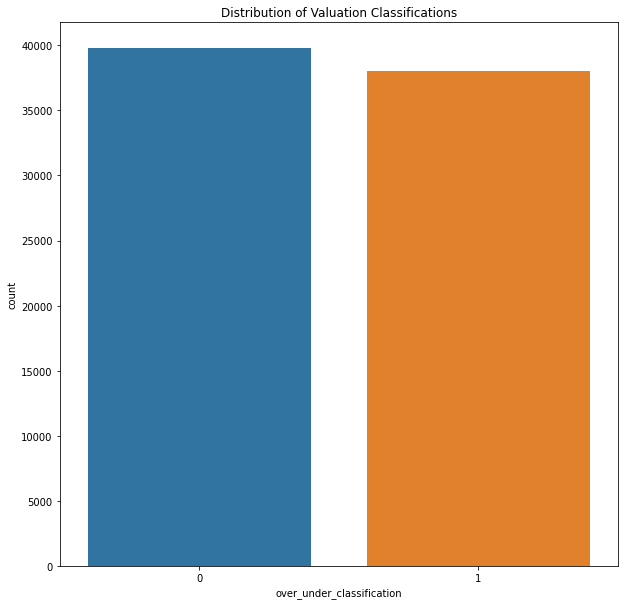

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Distribution of Valuation Classifications")

sns.countplot(x=hdb_class_data["over_under_classification"])

### Define Independent and Target Variables

In [7]:
# declare independent and dependent variables
X = hdb_class_data.drop(columns=['over_under_classification'])
y = hdb_class_data[['over_under_classification']]

In [8]:
# from sklearn.preprocessing import StandardScaler

# # initiatie standard scalers for x variables
# sc_x = StandardScaler()

# # scale x
# X = sc_x.fit_transform(X)

### Split Data into Training and Test Sets

In [9]:
#Split the dataset into training and testing data
from sklearn.model_selection import train_test_split

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Feature Selection for Logistic Regression

In [18]:
logreg_clf = LogisticRegression(random_state=42)
logreg_clf.fit(X_train, y_train)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=42)

In [19]:
print(logreg_clf.coef_)

[[ 0.97393468 -0.15559475  0.18269131 -0.15150234 -0.00942536 -0.40566927
   0.20579965  0.05043335]]


In [20]:
print(np.round(logreg_clf.coef_, decimals=2)>0)

[[ True False  True False False False  True  True]]


##### Recursive Feature Elimination Using Scikit-learn RFE

In [21]:
from sklearn.feature_selection import RFE   

predictors = X_train

# n_features_to_select = 1 to get full ranking of features
selector = RFE(logreg_clf, n_features_to_select=1)
selector = selector.fit(predictors, y_train)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversio

In [22]:
order = selector.ranking_
print(order)

[1 5 3 4 8 2 6 7]


##### Derive the Features Selected by RFE

In [23]:
features_ranked = []

for i in order:
   features_ranked.append(predictors.columns[i-1])

print(features_ranked)

['storey_range', 'remaining_lease_months', 'no.of bto', 'resale application', 'isMatureEstate', 'floor_area_sqm', 'Distance to nearest MRT', 'Distance to CBD']


### Select K Best Features

In [14]:
import sklearn.feature_selection as fs
import sklearn.metrics as metrics

f1_list = []

for k in range(1, 9):
   # use ANOVA F-value between label/feature to select k best features
   bk = fs.SelectKBest(score_func=fs.f_classif, k = k)
   bk.fit(X, y)
   X_trans = bk.transform(X)

   # split data
   train_x, test_x, train_y, test_y = train_test_split(X_trans,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=42)
   
   # fit model with k best features
   lr = LogisticRegression()
   lr.fit(train_x, train_y)
   y_pred_k = lr.predict(test_x)
   f1 = metrics.f1_score(test_y, y_pred_k)
   f1_list.append(f1)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversio

##### Plot Results of Select K Best

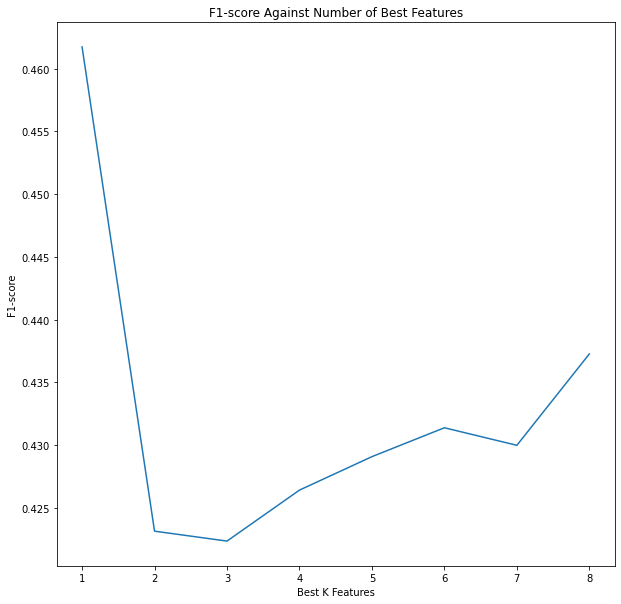

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("F1-score Against Number of Best Features")
ax.set_xlabel("Best K Features")
ax.set_ylabel("F1-score")

ax.plot(range(1, 9), f1_list)

### Train Logistic Regression Model With ALL Available Features From Dataset

In [26]:
logreg_clf_all = LogisticRegression(random_state=42)
logreg_clf_all.fit(X_train, y_train)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=42)

In [27]:
print(logreg_clf_all.coef_)

[[ 0.97393468 -0.15559475  0.18269131 -0.15150234 -0.00942536 -0.40566927
   0.20579965  0.05043335]]


In [28]:
print(logreg_clf_all.intercept_)

[-0.2220095]


##### Model Evaluation (Model Trained With ALL Available Features)

In [29]:
y_pred_all = logreg_clf_all.predict(X_test)

In [30]:
from sklearn.metrics import confusion_matrix

# generate confusion matrix for log reg
cnf = confusion_matrix(y_test, y_pred_all)
print("Confusion Matrix: \n", cnf)

Confusion Matrix: 
 [[5678 2249]
 [5042 2598]]


In [31]:
from sklearn.metrics import roc_auc_score

# generate roc_auc_score for log reg
roc_auc_score(y_test, y_pred_all)

0.5281692333908169

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Find accuracy, precision, recall, and f1 score
asr = accuracy_score(y_test, y_pred_all)
f1 = f1_score(y_test, y_pred_all)
precision = precision_score(y_test, y_pred_all)
recall = recall_score(y_test, y_pred_all)

print("Accuracy: " + str(asr))
print("F1: " + str(f1))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

Accuracy: 0.5316374381704888
F1: 0.4161127572675583
Precision: 0.5360016505054673
Recall: 0.3400523560209424


### Train Logistic Regression Model With Selected Features

In [16]:
# re-select independent and dependent variables
X_selected = hdb_class_data.drop(columns=['over_under_classification', 'Distance to nearest MRT', 'Distance to CBD'])
y_selected = hdb_class_data[['over_under_classification']]

In [17]:
# split data
X_selected_train, X_selected_test, y_selected_train, y_selected_test = train_test_split(X_selected, y_selected, test_size = 0.2, random_state = 0)

In [18]:
logreg_clf_all = LogisticRegression(random_state=42)
logreg_clf_all.fit(X_selected_train, y_selected_train)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=42)

In [19]:
print(logreg_clf_all.coef_)

[[ 0.93045636 -0.09440748  0.18154622 -0.14741762 -0.0437841   0.02071442]]


In [20]:
print(logreg_clf_all.intercept_)

[-0.18418091]


##### Model Evaluation (Model Trained With ALL Available Features)

In [21]:
y_pred = logreg_clf_all.predict(X_selected_test)

In [22]:
from sklearn.metrics import confusion_matrix

# generate confusion matrix for log reg
cnf = confusion_matrix(y_selected_test, y_pred)
print("Confusion Matrix: \n", cnf)

Confusion Matrix: 
 [[5861 2066]
 [5216 2424]]


In [23]:
from sklearn.metrics import roc_auc_score

# generate roc_auc_score for log reg
roc_auc_score(y_selected_test, y_pred)

0.5283246271441564

In [33]:
# Find accuracy, precision, recall, and f1 score
asr = accuracy_score(y_selected_test, y_pred)
f1 = f1_score(y_selected_test, y_pred)
precision = precision_score(y_selected_test, y_pred)
recall = recall_score(y_selected_test, y_pred)

print("Accuracy: " + str(asr))
print("F1: " + str(f1))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

Accuracy: 0.5322155842487313
F1: 0.39967023907666943
Precision: 0.5398663697104678
Recall: 0.3172774869109948
